# 06 - Market comparison (Asian options)
In this final notebook, we use actual marked data from `yfinance` to historically backtest our pricing model for Asian options.  We will take windows over historical data and compare the actual (discounted) payout of an array of Asian options to the expected one for geometric calls (from the formula) and arithmetic calls (from the Monte-Carlo simulation).  We will use realized volatility in the previous month as volatility in the GBM model.

Specifically, we will compute the discounted P&L of buying calls at prices indicated by our model and holding them to maturity.

As in the previous market comparison notebook, we will look at the following tickers:
- SPDR S&P 500 ETF Trust (`SPY`),
- Vanguard Total Stock Market Index Fund ETF (`VTI`),
- Apple Inc (`AAPL`),
- Microsoft Corp (`MSFT`).

Since Asian options are mostly used for commodities, we will also backtest with
- [Invesco Optimum Yield Diversified Commodity Strategy No K-1 ETF](https://etfdb.com/etf/PDBC/#etf-ticker-profile) (`PDBC`),
- [SPDR Gold Shares](https://www.spdrgoldshares.com/) (`GLD`).

We will take the start date of the historical series to be Jan 1, 2019, and the end date to be Dec 31, 2024.  We will look at options expiring in 5 days, to be consistent with the data of the previous market-comparison notebook, and compute realized volatility in the 21 days before the call contract is established.  Averages will be taken daily.

### Data pipeline

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from brokenaxes import brokenaxes

sns.set_style("darkgrid")

from utils import gao_price, monte_carlo_asian


# function to annualize realized vol
def realized_vol(series, window_days=60):
    # log returns
    lr = np.log(series).diff().dropna()
    return lr.rolling(window_days).std() * np.sqrt(252)


def backtest_asian(
    ticker,
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
    save_df=True,
    save_pic=True,
    bax_ylims=((0, 400), (3100, 3250)),
):
    prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()

    # compute rolling realized vol series (one-sided trailing)
    rv = realized_vol(prices, window_days=trail_window)

    # choose t0 dates where we have enough trailing data and future window
    all_dates = prices.index
    usable_dates = []
    for t0 in all_dates:
        # require t0 to have trailing window and future expiry window
        t0_idx = all_dates.get_loc(t0)
        if t0_idx - trail_window < 0:
            continue
        # compute end index for expiry
        expiry_date = t0 + pd.Timedelta(days=expiry_days)
        # find nearest trading day >= expiry_date
        if expiry_date > all_dates[-1]:
            break
        # we need expiry to be in index
        # find first trading day >= expiry_date
        future_idx = all_dates.get_indexer([expiry_date], method="bfill")[0]
        if future_idx == -1 or future_idx >= len(all_dates):
            continue
        # accept t0
        usable_dates.append(t0)

    # # For speed, subsample usable_dates
    # usable_dates = usable_dates[::20]

    results = []
    for t0 in usable_dates:
        for K_rel in K_rel_values:
            # get S0 at t0
            S0 = float(prices.loc[t0])
            # strike
            K = K_rel * S0

            # compute realized vol at t0 using trailing window
            sigma_t0 = float(rv.loc[t0])
            if np.isnan(sigma_t0) or sigma_t0 <= 0:
                continue

            # determine expiry trading day index
            expiry_date = t0 + pd.Timedelta(days=expiry_days)
            expiry_idx = prices.index.get_indexer([expiry_date], method="bfill")[0]
            T_days = expiry_idx - prices.index.get_indexer([t0])[0]
            # convert to years
            T_years = T_days / 252.0

            # --- Model price at t0 using realized vol ---
            # geometric
            model_G_price = gao_price(S0, K, sigma_t0, T_years, r)
            # arithmetic
            model_A_price = monte_carlo_asian(
                S0,
                K,
                sigma_t0,
                T_years,
                r,
                0,
                n_sims,
                n_steps,
                return_distribution=False,
            )

            # --- Empirical realized payoff computed from actual future prices ---
            # we need the actual average from t0->expiry_date inclusive
            # get slice of future prices from the first trading day after t0 up to expiry_idx
            t0_idx = prices.index.get_loc(t0)
            future_slice = prices.iloc[
                t0_idx + 1 : expiry_idx + 1
            ]  # average over next T_days (exclude t0)
            if len(future_slice) == 0:
                continue

            # geometric average
            G_T = np.exp(np.mean(np.log(future_slice)))
            discounted_G_payoff = max(G_T - K, 0) * np.exp(-r * T_years)

            # arithmetic average
            A_T = np.mean(future_slice)
            discounted_A_payoff = max(A_T - K, 0) * np.exp(-r * T_years)

            # store
            results.append(
                {
                    "t0": t0,
                    "S0": S0,
                    "K": K,
                    "K_rel": K_rel,
                    "sigma_t0": sigma_t0,
                    "T_years": T_years,
                    "geom_model": model_G_price,
                    "arit_model": model_A_price,
                    "geom_empirical": discounted_G_payoff,
                    "arit_empirical": discounted_A_payoff,
                }
            )

    results = pd.DataFrame(results)
    results = results.dropna().reset_index(drop=True)

    if save_df:
        results.to_csv(f"outputs/{ticker}_asian.csv")

    # --- Basic summary stats ---
    print("Geometric Asian call option")
    bias_G = (results["geom_model"] - results["geom_empirical"]).mean()
    mae_G = np.mean(np.abs(results["geom_model"] - results["geom_empirical"]))
    print(f"Mean model - empirical price: {bias_G:.4f}, MAE: {mae_G:.4f}")
    print()
    print("Arithmetic Asian call option")
    bias_A = (results["arit_model"] - results["arit_empirical"]).mean()
    mae_A = np.mean(np.abs(results["arit_model"] - results["arit_empirical"]))
    print(f"Mean model - empirical price: {bias_A:.4f}, MAE: {mae_A:.4f}")

    # --- Plot model vs empirical over time ---
    # geometric
    plt.figure(figsize=(10, 5))
    plt.plot(results["t0"], results["geom_model"], label="Geometric model price")
    plt.plot(
        results["t0"],
        results["geom_empirical"],
        label="Empirical geometric discounted payoff",
        alpha=0.8,
    )
    plt.legend()
    plt.ylabel("Price")
    plt.title(
        f"Geometric Asian model price vs empirical realized discounted payoff ({ticker})"
    )
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.show()

    # arithmetic
    plt.figure(figsize=(10, 5))
    plt.plot(results["t0"], results["arit_model"], label="Arithmetic model price")
    plt.plot(
        results["t0"],
        results["arit_empirical"],
        label="Empirical arithmetic discounted payoff",
        alpha=0.8,
    )
    plt.legend()
    plt.ylabel("Price")
    plt.title(
        f"Arithmetic Asian model price vs empirical realized discounted payoff ({ticker})"
    )
    plt.xticks(rotation=30)
    plt.grid(True)
    plt.show()

    # --- VaR-like experiment: distribution of P&L if you sold at model price at t0 ---
    # pnl = discounted_payoff - model_price (realized payoff minus model price)
    results["geom_pnl"] = results["geom_empirical"] - results["geom_model"]
    results["arit_pnl"] = results["arit_empirical"] - results["arit_model"]

    n_bins = 100

    # geometric
    # summary metrics
    print("Geometric call")
    mean = results["geom_pnl"].mean()
    VaR = results["geom_pnl"].quantile(0.05)
    median = np.median(results["geom_pnl"])
    print(f"P&L median: ${median:.3f}")
    print(f"P&L mean: ${mean:.3f}")
    print(f"P&L std: ${results['geom_pnl'].std():.3f}")
    print(f"VaR (95): ${VaR:.3f}")

    # histogram
    plt.figure(figsize=(7, 4))
    bax = brokenaxes(ylims=bax_ylims)
    bax.hist(results["geom_pnl"], bins=n_bins)
    # bax.text(-25, 3150, f"P&L median: ${median:.3f}")
    bax.axvline(mean, label=f"Mean ${mean:.3f}", color="black")
    bax.axvline(VaR, label=f"VaR (95) ${VaR:.3f}", color="red")
    plt.title(f"Distribution of realized P&L for one geometric {ticker} call")
    bax.set_xlabel("Realized P&L (discounted)")
    bax.legend()
    if save_pic:
        plt.savefig(f"pictures/{ticker}_geometric_calls.png")
    plt.show()

    # arithmetic
    # summary metrics
    print("Arithmetic call")
    mean = results["arit_pnl"].mean()
    VaR = results["arit_pnl"].quantile(0.05)
    median = np.median(results["arit_pnl"])
    print(f"P&L median: ${median:.3f}")
    print(f"P&L mean: ${mean:.3f}")
    print(f"P&L std: ${results['arit_pnl'].std():.3f}")
    print(f"VaR (95): ${VaR:.3f}")

    # histogram
    plt.figure(figsize=(7, 4))
    bax = brokenaxes(ylims=bax_ylims)
    bax.hist(results["arit_pnl"], bins=n_bins)
    # bax.text(-25, 3150, f"P&L median: ${median:.3f}")
    bax.axvline(mean, label=f"Mean ${mean:.3f}", color="black")
    bax.axvline(VaR, label=f"VaR (95) ${VaR:.3f}", color="red")
    plt.title(f"Distribution of realized P&L for one arithmetic {ticker} call")
    bax.set_xlabel("Realized P&L (discounted)")
    bax.legend()
    if save_pic:
        plt.savefig(f"pictures/{ticker}_arithmetic_calls.png")
    plt.show()

    return results

### Simulation config

In [2]:
expiry_days = 5  # length of Asian contract in calendar days
trail_window = 21  # days to compute realized vol before t0
r = 0.045  # risk-free rate (annual)
n_sims = 20_000  # MC paths for model pricing
n_steps = expiry_days  # MC time steps approx 1 per day
K_rel_values = [0.8, 0.9, 1.0, 1.1, 1.2]  # strike relative to spot, e.g., 1.0 = ATM
start_date = "2019-01-01"  # historical range start
end_date = "2024-12-31"  # historical range end

### `SPY`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.2725, MAE: 2.0198

Arithmetic Asian call option
Mean model - empirical price: -0.2853, MAE: 2.0171


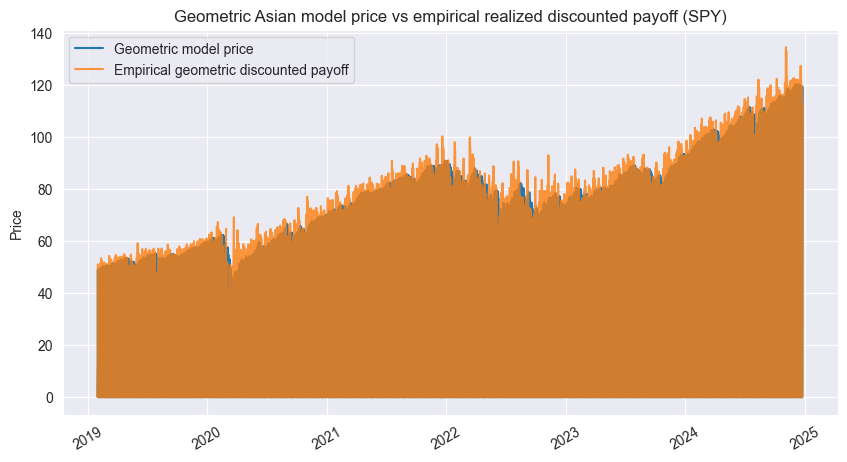

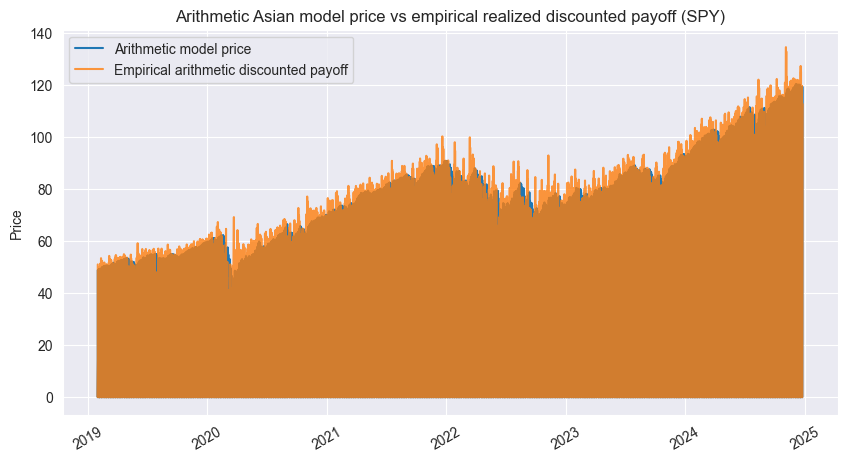

Geometric call
P&L median: $-0.000
P&L mean: $0.272
P&L std: $3.712
VaR (95): $-4.974


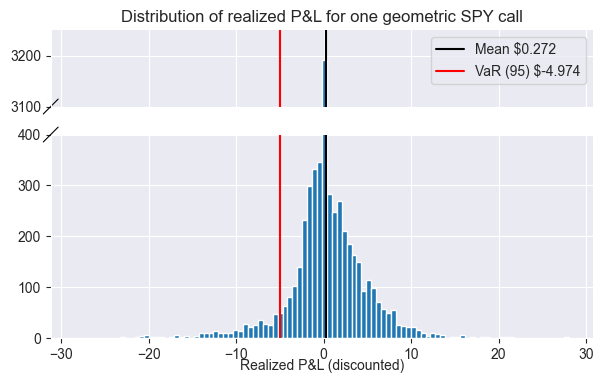

Arithmetic call
P&L median: $0.000
P&L mean: $0.285
P&L std: $3.710
VaR (95): $-4.980


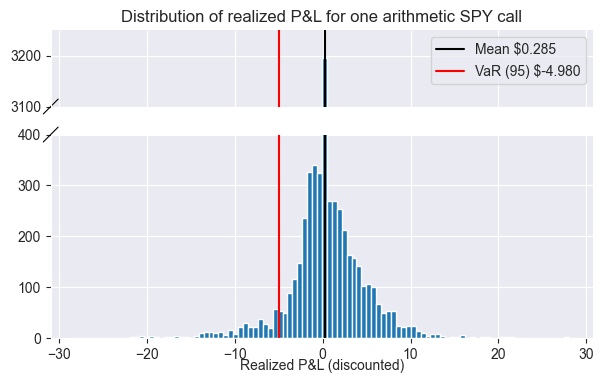

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,243.591797,194.873438,0.8,0.181795,0.011905,4.874950e+01,48.763069,50.981661,50.982036,2.232157e+00,2.218967
1,2019-02-01,243.591797,219.232617,0.9,0.181795,0.011905,2.440337e+01,24.413413,26.635527,26.635902,2.232157e+00,2.222489
2,2019-02-01,243.591797,243.591797,1.0,0.181795,0.011905,1.141278e+00,1.079419,2.289394,2.289768,1.148116e+00,1.210349
3,2019-02-01,243.591797,267.950977,1.1,0.181795,0.011905,1.753667e-17,0.000000,0.000000,0.000000,-1.753667e-17,0.000000
4,2019-02-01,243.591797,292.310156,1.2,0.181795,0.011905,6.044625e-58,0.000000,0.000000,0.000000,-6.044625e-58,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,596.076965,476.861572,0.8,0.137460,0.011905,1.193000e+02,119.310596,112.743727,112.767637,-6.556246e+00,-6.542960
7421,2024-12-24,596.076965,536.469269,0.9,0.137460,0.011905,5.972420e+01,59.808449,53.167955,53.191864,-6.556246e+00,-6.616585
7422,2024-12-24,596.076965,596.076965,1.0,0.137460,0.011905,2.133367e+00,2.024214,0.000000,0.000000,-2.133367e+00,-2.024214
7423,2024-12-24,596.076965,655.684662,1.1,0.137460,0.011905,1.181532e-28,0.000000,0.000000,0.000000,-1.181532e-28,0.000000


In [3]:
backtest_asian(
    "SPY",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
)

### `VTI`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.1343, MAE: 1.0522

Arithmetic Asian call option
Mean model - empirical price: -0.1411, MAE: 1.0509


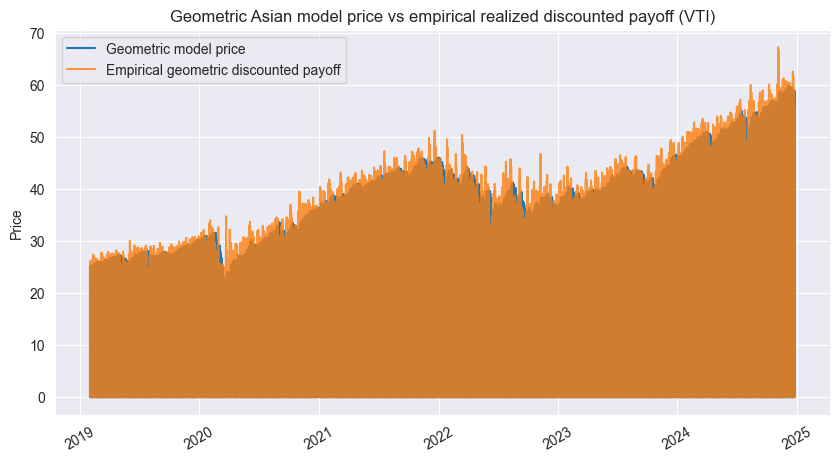

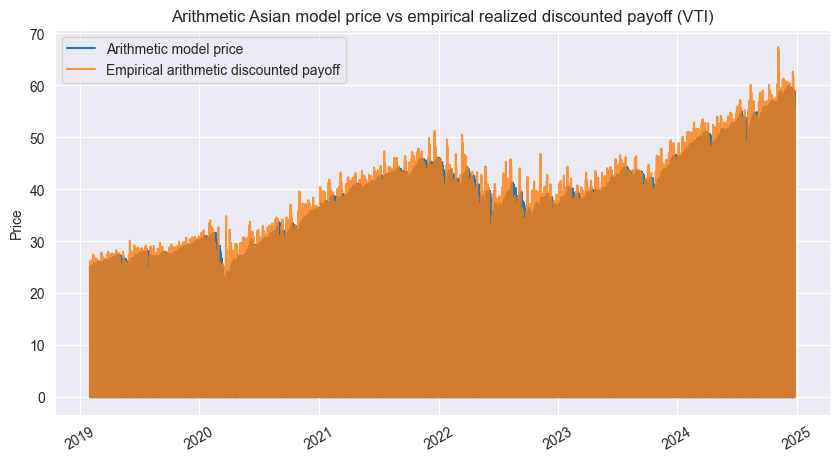

Geometric call
P&L median: $-0.000
P&L mean: $0.134
P&L std: $1.931
VaR (95): $-2.666


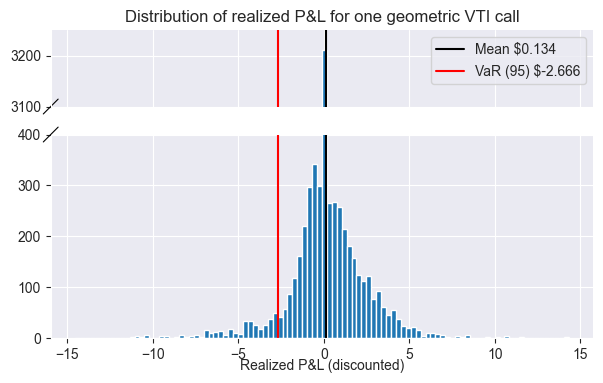

Arithmetic call
P&L median: $0.000
P&L mean: $0.141
P&L std: $1.930
VaR (95): $-2.669


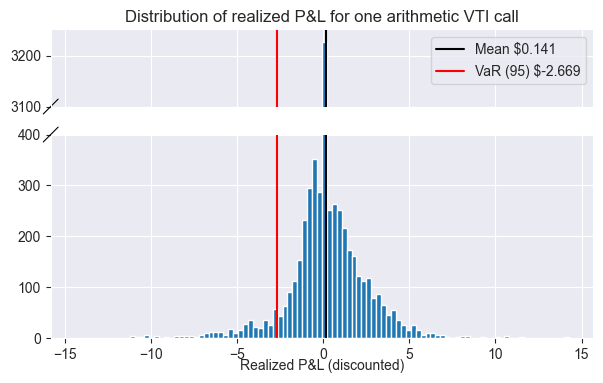

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,124.977295,99.981836,0.8,0.180145,0.011905,2.501151e+01,25.024715,26.179390,26.179586,1.167877e+00,1.154871
1,2019-02-01,124.977295,112.479565,0.9,0.180145,0.011905,1.252048e+01,12.537246,13.688354,13.688550,1.167877e+00,1.151304
2,2019-02-01,124.977295,124.977295,1.0,0.180145,0.011905,5.804015e-01,0.556371,1.197318,1.197514,6.169161e-01,0.641143
3,2019-02-01,124.977295,137.475024,1.1,0.180145,0.011905,4.647443e-18,0.000000,0.000000,0.000000,-4.647443e-18,0.000000
4,2019-02-01,124.977295,149.972754,1.2,0.180145,0.011905,2.947841e-59,0.000000,0.000000,0.000000,-2.947841e-59,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,294.369537,235.495630,0.8,0.141683,0.011905,5.891533e+01,58.902615,55.800616,55.812363,-3.114717e+00,-3.090251
7421,2024-12-24,294.369537,264.932584,0.9,0.141683,0.011905,2.949414e+01,29.478415,26.379427,26.391175,-3.114717e+00,-3.087240
7422,2024-12-24,294.369537,294.369537,1.0,0.141683,0.011905,1.084591e+00,1.040386,0.000000,0.000000,-1.084591e+00,-1.040386
7423,2024-12-24,294.369537,323.806491,1.1,0.141683,0.011905,2.192925e-27,0.000000,0.000000,0.000000,-2.192925e-27,0.000000


In [4]:
backtest_asian(
    "VTI",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
)

### `AAPL`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.1797, MAE: 1.2002

Arithmetic Asian call option
Mean model - empirical price: -0.1877, MAE: 1.1998


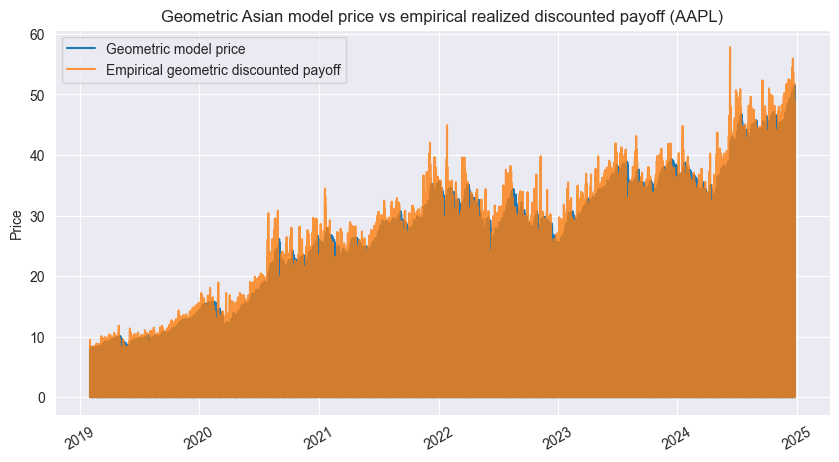

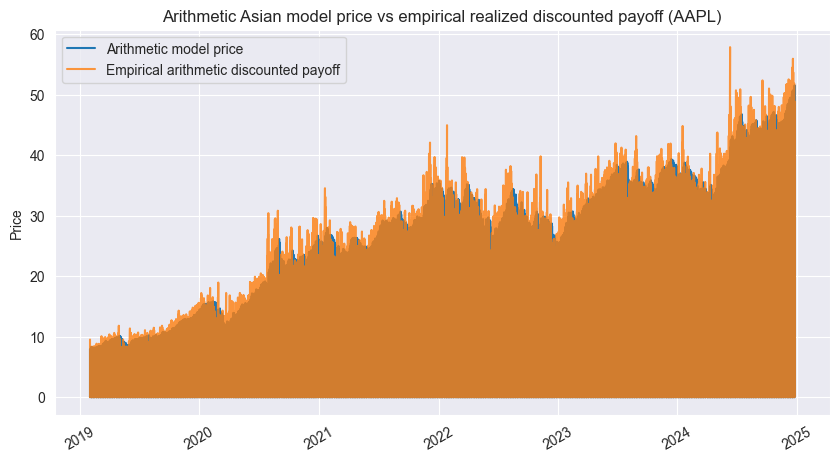

Geometric call
P&L median: $-0.000
P&L mean: $0.180
P&L std: $2.189
VaR (95): $-2.930


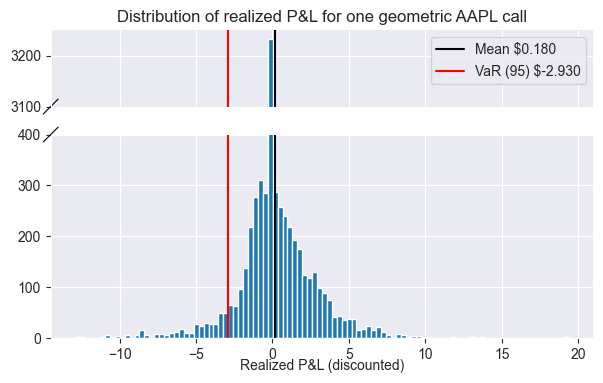

Arithmetic call
P&L median: $0.000
P&L mean: $0.188
P&L std: $2.191
VaR (95): $-2.931


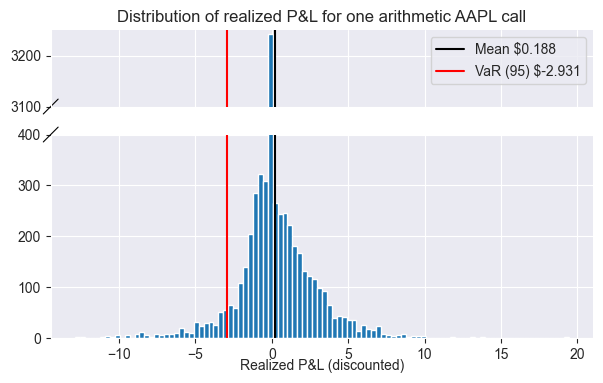

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,39.621479,31.697183,0.8,0.508348,0.011905,7.920507e+00,7.926369,9.512830,9.514172,1.592323e+00,1.587803
1,2019-02-01,39.621479,35.659331,0.9,0.508348,0.011905,3.960640e+00,3.964855,5.552804,5.554146,1.592165e+00,1.589291
2,2019-02-01,39.621479,39.621479,1.0,0.508348,0.011905,5.061138e-01,0.493848,1.592778,1.594120,1.086664e+00,1.100272
3,2019-02-01,39.621479,43.583627,1.1,0.508348,0.011905,5.531311e-04,0.000677,0.000000,0.000000,-5.531311e-04,-0.000677
4,2019-02-01,39.621479,47.545775,1.2,0.508348,0.011905,1.439740e-09,0.000000,0.000000,0.000000,-1.439740e-09,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,257.286682,205.829346,0.8,0.139259,0.011905,5.149372e+01,51.525159,48.828541,48.843644,-2.665176e+00,-2.681515
7421,2024-12-24,257.286682,231.558014,0.9,0.139259,0.011905,2.577883e+01,25.769348,23.113652,23.128755,-2.665176e+00,-2.640593
7422,2024-12-24,257.286682,257.286682,1.0,0.139259,0.011905,9.323871e-01,0.902692,0.000000,0.000000,-9.323871e-01,-0.902692
7423,2024-12-24,257.286682,283.015350,1.1,0.139259,0.011905,2.486568e-28,0.000000,0.000000,0.000000,-2.486568e-28,0.000000


In [5]:
backtest_asian(
    "AAPL",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
)

### `MSFT`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.2609, MAE: 2.1007

Arithmetic Asian call option
Mean model - empirical price: -0.2743, MAE: 2.0978


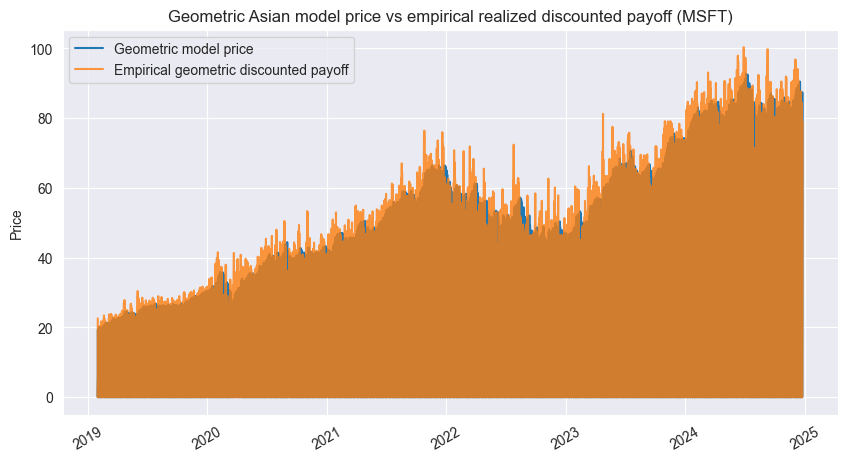

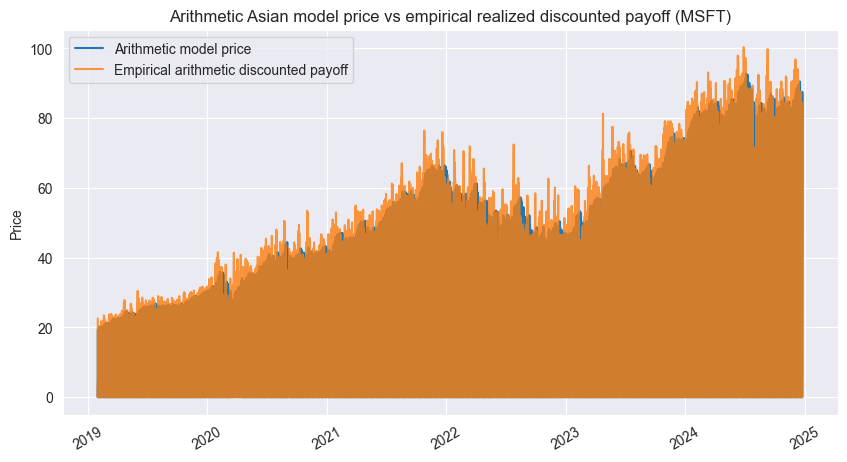

Geometric call
P&L median: $-0.000
P&L mean: $0.261
P&L std: $3.793
VaR (95): $-5.230


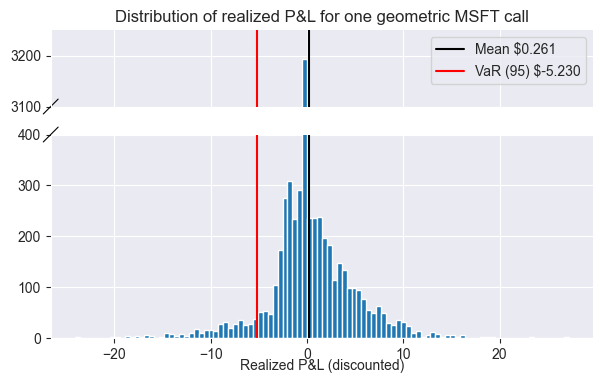

Arithmetic call
P&L median: $0.000
P&L mean: $0.274
P&L std: $3.792
VaR (95): $-5.255


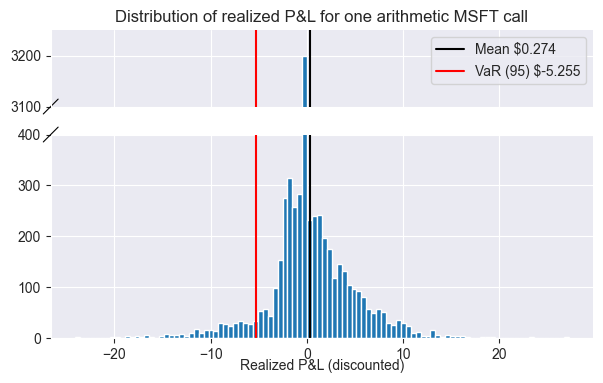

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,96.345764,77.076611,0.8,0.317865,0.011905,1.927498e+01,19.262449,22.583007,22.584809,3.308032e+00,3.322360
1,2019-02-01,96.345764,86.711188,0.9,0.317865,0.011905,9.645559e+00,9.671731,12.953591,12.955393,3.308032e+00,3.283662
2,2019-02-01,96.345764,96.345764,1.0,0.317865,0.011905,7.773741e-01,0.749687,3.324174,3.325977,2.546800e+00,2.576289
3,2019-02-01,96.345764,105.980341,1.1,0.317865,0.011905,3.980582e-07,0.000000,0.000000,0.000000,-3.980582e-07,0.000000
4,2019-02-01,96.345764,115.614917,1.2,0.317865,0.011905,1.054028e-20,0.000000,0.000000,0.000000,-1.054028e-20,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,436.929138,349.543311,0.8,0.198014,0.011905,8.743902e+01,87.507469,79.180625,79.214687,-8.258398e+00,-8.292781
7421,2024-12-24,436.929138,393.236224,0.9,0.198014,0.011905,4.376951e+01,43.780087,35.511112,35.545174,-8.258398e+00,-8.234913
7422,2024-12-24,436.929138,436.929138,1.0,0.198014,0.011905,2.223725e+00,2.150308,0.000000,0.000000,-2.223725e+00,-2.150308
7423,2024-12-24,436.929138,480.622052,1.1,0.198014,0.011905,9.027539e-15,0.000000,0.000000,0.000000,-9.027539e-15,0.000000


In [6]:
backtest_asian(
    "MSFT",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
)

### `PDBC`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.0049, MAE: 0.0679

Arithmetic Asian call option
Mean model - empirical price: -0.0053, MAE: 0.0679


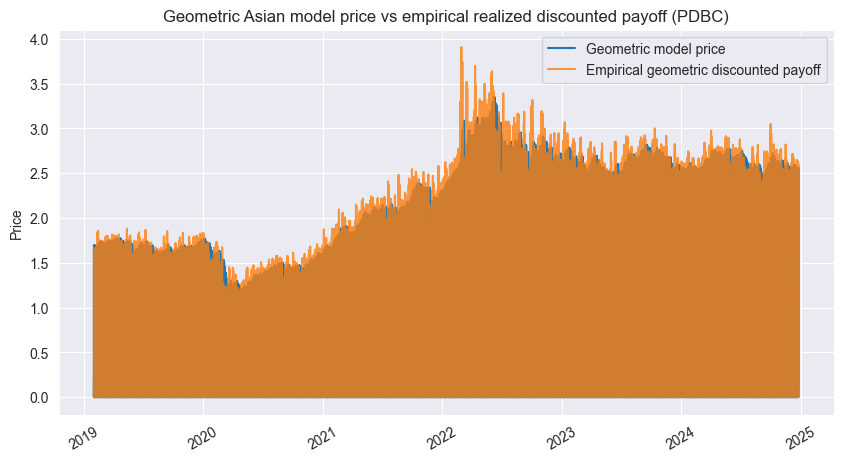

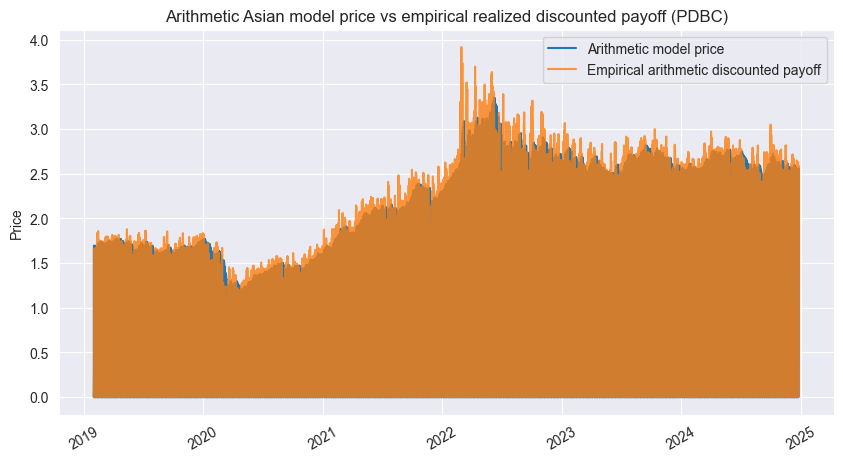

Geometric call
P&L median: $-0.000
P&L mean: $0.005
P&L std: $0.130
VaR (95): $-0.183


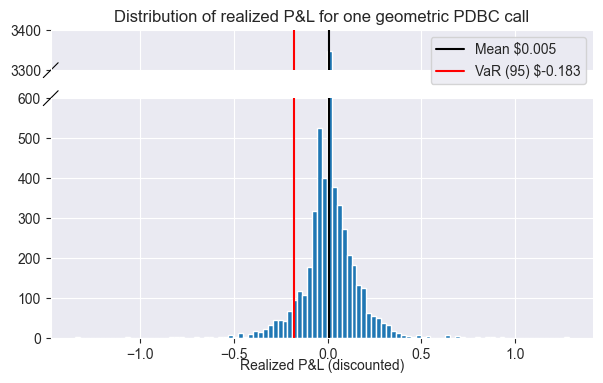

Arithmetic call
P&L median: $0.000
P&L mean: $0.005
P&L std: $0.130
VaR (95): $-0.183


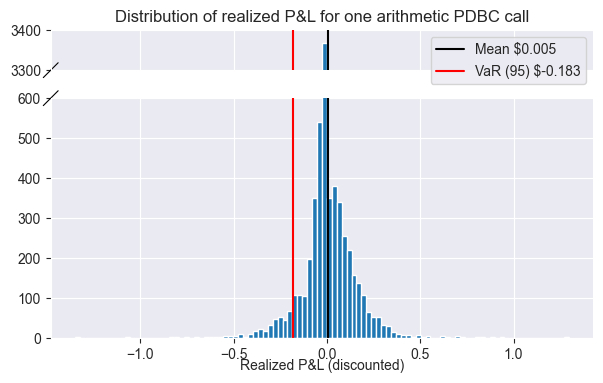

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,8.469308,6.775446,0.8,0.129226,0.011905,1.695082e+00,1.695376,1.666999,1.667021,-2.808272e-02,-0.028355
1,2019-02-01,8.469308,7.622377,0.9,0.129226,0.011905,8.486046e-01,0.849022,0.820522,0.820544,-2.808272e-02,-0.028478
2,2019-02-01,8.469308,8.469308,1.0,0.129226,0.011905,2.857019e-02,0.027939,0.000000,0.000000,-2.857019e-02,-0.027939
3,2019-02-01,8.469308,9.316239,1.1,0.129226,0.011905,5.078999e-34,0.000000,0.000000,0.000000,-5.078999e-34,0.000000
4,2019-02-01,8.469308,10.163169,1.2,0.129226,0.011905,1.416597e-113,0.000000,0.000000,0.000000,-1.416597e-113,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,12.800000,10.240000,0.8,0.116096,0.011905,2.561885e+00,2.561912,2.591747,2.591945,2.986169e-02,0.030033
7421,2024-12-24,12.800000,11.520000,0.9,0.116096,0.011905,1.282571e+00,1.282385,1.312432,1.312630,2.986169e-02,0.030245
7422,2024-12-24,12.800000,12.800000,1.0,0.116096,0.011905,3.898077e-02,0.037199,0.033118,0.033316,-5.862995e-03,-0.003884
7423,2024-12-24,12.800000,14.080000,1.1,0.116096,0.011905,4.716532e-41,0.000000,0.000000,0.000000,-4.716532e-41,0.000000


In [7]:
backtest_asian(
    "PDBC",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
    bax_ylims=((0, 600), (3300, 3400)),
)

### `GLD`

/tmp/ipykernel_13734/2304058599.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(ticker, start=start_date, end=end_date)["Close"].dropna()
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_13734/2304058599.py:68: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  S0 = float(prices.loc[t0])
/tmp/ipykernel_13734/2304058599.py:73: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma_t0 = float(rv.loc[t0])


Geometric Asian call option
Mean model - empirical price: -0.0839, MAE: 0.8362

Arithmetic Asian call option
Mean model - empirical price: -0.0896, MAE: 0.8353


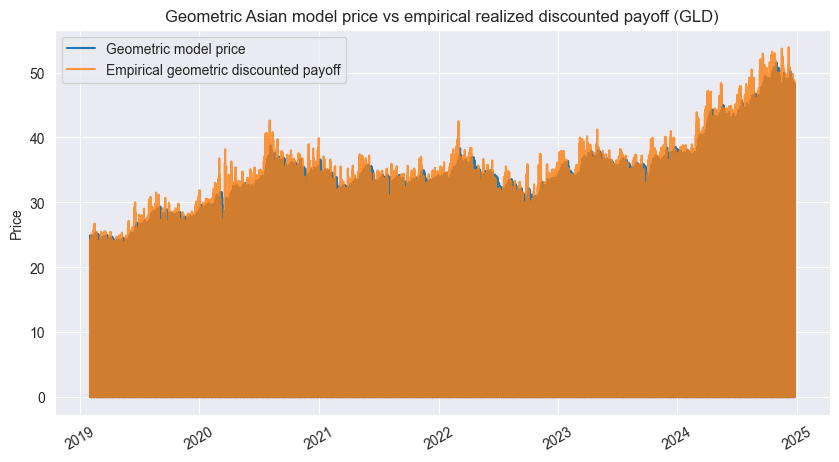

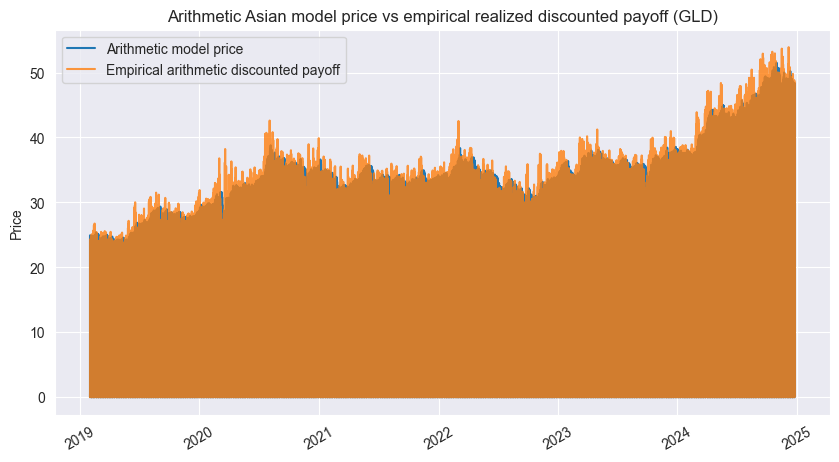

Geometric call
P&L median: $-0.000
P&L mean: $0.084
P&L std: $1.503
VaR (95): $-2.102


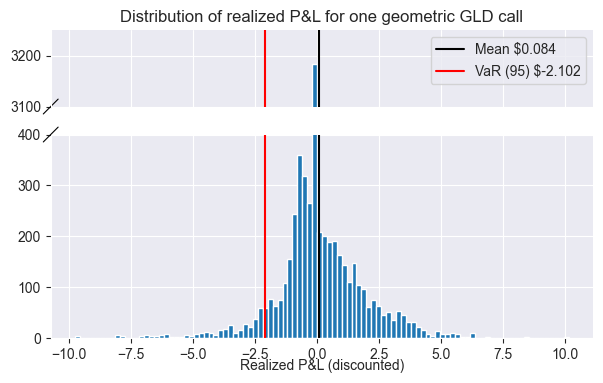

Arithmetic call
P&L median: $0.000
P&L mean: $0.090
P&L std: $1.503
VaR (95): $-2.099


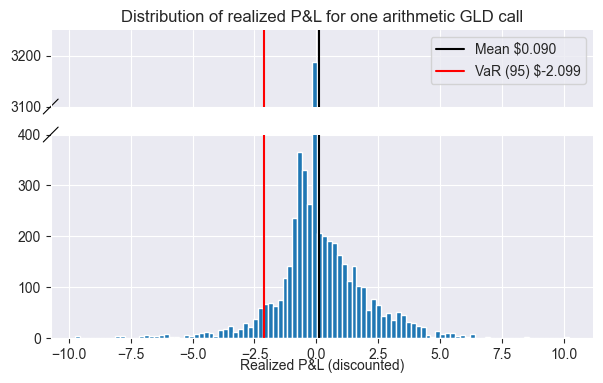

,t0,S0,K,K_rel,sigma_t0,T_years,geom_model,arit_model,geom_empirical,arit_empirical,geom_pnl,arit_pnl
0,2019-02-01,124.500000,99.600000,0.8,0.088562,0.011905,2.491903e+01,24.922130,24.279839,24.280323,-6.391916e-01,-0.641807
1,2019-02-01,124.500000,112.050000,0.9,0.088562,0.011905,1.247570e+01,12.479493,11.836507,11.836990,-6.391916e-01,-0.642502
2,2019-02-01,124.500000,124.500000,1.0,0.088562,0.011905,2.934649e-01,0.287879,0.000000,0.000000,-2.934649e-01,-0.287879
3,2019-02-01,124.500000,136.950000,1.1,0.088562,0.011905,9.188318e-67,0.000000,0.000000,0.000000,-9.188318e-67,0.000000
4,2019-02-01,124.500000,149.400000,1.2,0.088562,0.011905,1.568793e-235,0.000000,0.000000,0.000000,-1.568793e-235,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
7420,2024-12-24,241.440002,193.152002,0.8,0.171093,0.011905,4.831977e+01,48.353299,48.519857,48.521999,2.000823e-01,0.168700
7421,2024-12-24,241.440002,217.296002,0.9,0.171093,0.011905,2.418871e+01,24.167857,24.388788,24.390930,2.000823e-01,0.223073
7422,2024-12-24,241.440002,241.440002,1.0,0.171093,0.011905,1.066762e+00,1.026873,0.257718,0.259860,-8.090435e-01,-0.767013
7423,2024-12-24,241.440002,265.584003,1.1,0.171093,0.011905,1.711404e-19,0.000000,0.000000,0.000000,-1.711404e-19,0.000000


In [8]:
backtest_asian(
    "GLD",
    expiry_days,
    trail_window,
    r,
    n_sims,
    n_steps,
    K_rel_values,
    start_date,
    end_date,
)

### A few remarks about the results
Note first that the average P&L is positive in all cases, but recall that the B-S/M-C pricing for European options seems to be systematically underpricing calls compared to their real market prices, which we can assume to be a reasonable proxy for future discounted realized payoffs.  A similar phenomenon is probably happening for Asian options too, and could explain the consistent positive average P&L.  This likely reflects the difference between the risk-neutral dynamics assumed by the model and the empirical (real-world) dynamics, in particular the presence of a volatility risk premium or deviations from log-normality.

Note also that, although the mean P&L is positive, the distribution is skewed, and the median is practically indistinguishable from 0 and has a very large count.

Finally, note that the standard deviation and 95% Value-at-Risk of P&L substantially exceed the mean in all cases, indicating that the model’s apparent profitability is not statistically or economically significant.